In [3]:
import numpy as np
import control                   
import math
import cmath
import matplotlib.pyplot as plt
from scipy import linalg
import sympy as sp
import pandas as pd
from pprint import pprint
import array_to_latex

import sys
sys.path.append('../')
from control_utils import *

from IPython.display import display, Markdown, Latex

# Sistema original

{'Mp': 29.96660206480391,
 'tp': 0.01915,
 'ts5': 0.044950000000000004,
 'ts2': 0.06146000000000001,
 'tr': 0.007980000000000001,
 'td': 0.006920000000000001,
 'ess': -0.0019587385486283804,
 'final_value_step_simulated': 1.0019587385486284,
 'final_value_step_theoretical': -1}

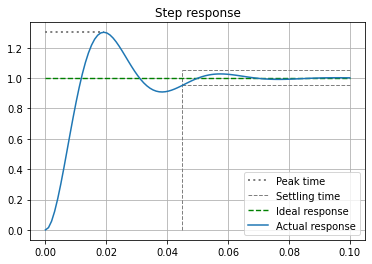

In [4]:
# Valores do circuito
R1 = 34000
R2 = 18000
C1 = 78e-9
C2 = 680e-9
tfinal = 0.1

# Definição do sistema
A = np.array([[0, 1/(R2*C1)], [-1/(R1*C2), (-R1-R2)/(R1*R2*C2)]])
B = np.array([[0], [1/(R1*C2)]])
C = np.array([[1, 0]])
D = np.array([[0]])

sys_original = control.ss(A, B, C, D)
sys_original_parameters: dict = step_info(sys_original, tfinal)
sys_original_parameters

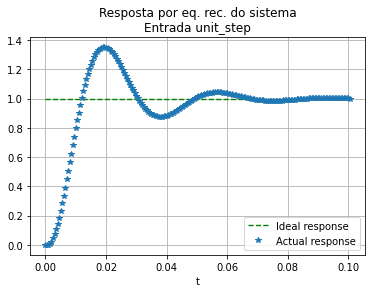

In [5]:
Y_reqeq_original, t_reqeq_original, X_reqeq_original = ee_reqeq_exec(
    sys = sys_original,
    initial_conditions = np.matrix('0; 0'),
    T = 0.0005,
    tfinal = tfinal,
)

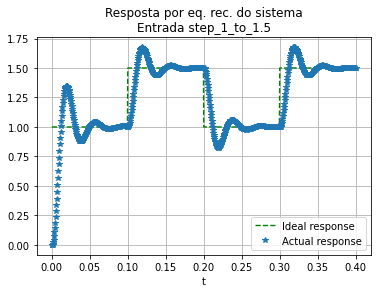

In [6]:
Y_reqeq_original, t_reqeq_original, X_reqeq_original = ee_reqeq_exec(
    sys = sys_original,
    initial_conditions = np.matrix('0; 0'),
    T = 0.0005,
    tfinal = tfinal*4,
    input_function = 'step_1_to_1.5',
)

# Controlador

In [7]:
controlable = test_controlability(sys_original)
assert controlable, 'O sistema não é controlável!!!'

# Requirements
name = 'Leonardo Santiago Benitez Pereira'
l = len(name)

desired_ts5_original = len(name)
print(f'ts5 desejado (original): {desired_ts5_original} ms')
desired_ts5 = desired_ts5_original - 5 #margem de segurança
print(f'ts5 desejado (com margem): {desired_ts5} ms')
desired_ts5 = desired_ts5/1000
desired_Mp_original = 2*len(name.split()[0])
print(f'Mp desejado (original): {desired_Mp_original} %')
desired_Mp = desired_Mp_original - 1 #margem de segurança
print(f'Mp desejado (com margem): {desired_Mp} %')
desired_Mp = desired_Mp/100

zeta, wn = parameters_from_metrics(Mp=desired_Mp, ts5=desired_ts5)

eigenvalues = np.roots([1, 2*zeta*wn,  wn**2]).tolist()
eigenvalues.append(5*np.real(eigenvalues[0]))
print('Ou seja, o sistema deve possuir os autovalores:', eigenvalues)

#escolha do perído de amostragem
# 15 vezes 
heuristic_margin = 15
T = desired_ts5/heuristic_margin
print(f'O período de amostragem foi escolhido como sendo T={T*1000}ms, {heuristic_margin} vezes menor do que o tempo de subida desejado ts5={desired_ts5}s')


The controlability matrix is:
[[   0.          712.25071225    0.        ]
 [ -43.25259516 -124.95194156   43.25259516]
 [  -1.           -0.            0.        ]]
Whose rank is:
3
Therefore, the system is controlable.
ts5 desejado (original): 33 ms
ts5 desejado (com margem): 28 ms
Mp desejado (original): 16 %
Mp desejado (com margem): 15 %
Ou seja, o sistema deve possuir os autovalores: [(-107.14285714285714+177.42642298128987j), (-107.14285714285714-177.42642298128987j), -535.7142857142857]
O período de amostragem foi escolhido como sendo T=1.8666666666666667ms, 15 vezes menor do que o tempo de subida desejado ts5=0.028s


**Matrizes expandidas:**
![](controlled_expanded_matrices.png)

In [8]:
A_hat = np.block([[A, np.zeros_like(C.T)],[-C, 0]])
B_hat = np.block([[B],[0]])
K_hat = control.acker(A_hat, B_hat, eigenvalues)
K_contr = K_hat[:, :-1]
k_contr_i = -K_hat[0, -1]
eigenvalues_servo = np.linalg.eig(A_hat-B_hat*K_hat)[0]
print('K_hat =', K_hat)

K_hat = [[   4.12082398   14.45111111 -747.0500209 ]]


**Novo sistema (controlado):**
![](controlled_new_system.png)

{'Mp': 13.666159212368903,
 'tp': 0.01992,
 'ts5': 0.027440000000000003,
 'ts2': 0.038740000000000004,
 'tr': 0.008820000000000001,
 'td': 0.008100000000000001,
 'ess': -1.363072015569955e-05,
 'final_value_step_simulated': 1.0000136307201557,
 'final_value_step_theoretical': -1}

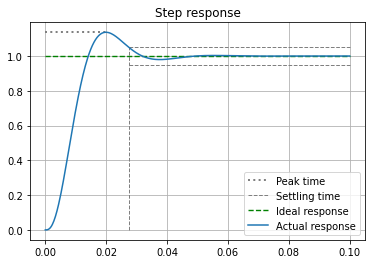

In [9]:
AA_contr = np.block([[A-B*K_contr, B*k_contr_i],[-C, 0]]) 
BB_contr = np.concatenate((np.zeros((AA_contr.shape[0]-1,1)), [[1]]))
CC_contr = np.matrix(np.concatenate((C[0, :], [0.0])))
DD_contr = np.matrix([0.0])
sys_contr = control.ss(AA_contr, BB_contr, CC_contr, DD_contr)
step_info(sys_contr, tfinal)

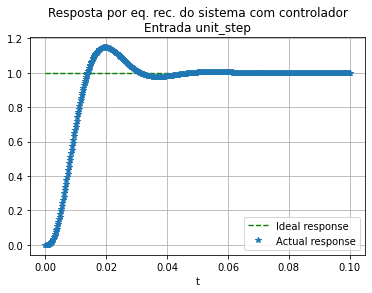

In [10]:
Y_reqeq, t_reqeq, X_reqeq = ee_reqeq_exec_with_controller(
    sys_original = sys_original,
    initial_conditions = np.matrix([[0], [0], [0]]),
    T = T/10,
    tfinal = tfinal,
    K_contr = K_contr,
    k_contr_i = k_contr_i,
)

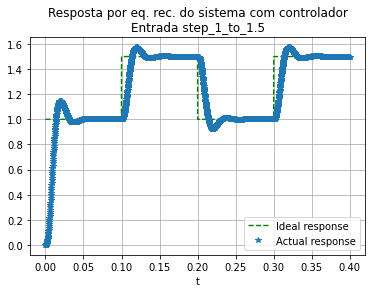

In [20]:
Y_reqeq, t_reqeq, X_reqeq = ee_reqeq_exec_with_controller(
    sys_original = sys_original,
    initial_conditions = np.matrix([[0], [0], [0]]),
    T = T/10,
    tfinal = tfinal*4,
    K_contr = K_contr,
    k_contr_i = k_contr_i,
    input_function = 'step_1_to_1.5',
)

# Observador

Sistema resultante:
![](observed_new_system.png)

The observability matrix is:
[[  1.           0.        ]
 [  0.         712.25071225]]
Whose rank is:
2
Therefore, the system is fully observable.
Ke = [[ 4160.76234415]
 [23352.99726963]]


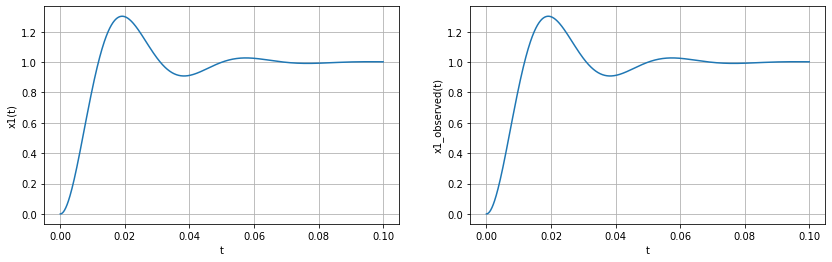

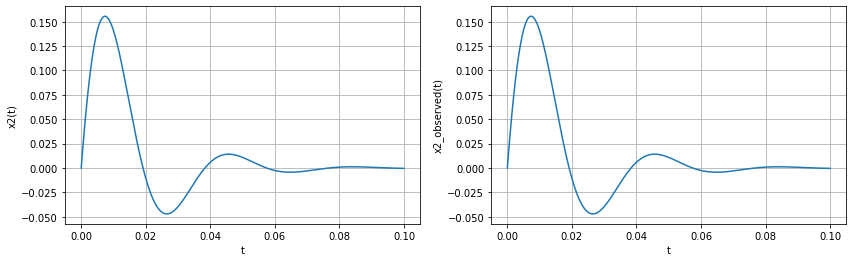

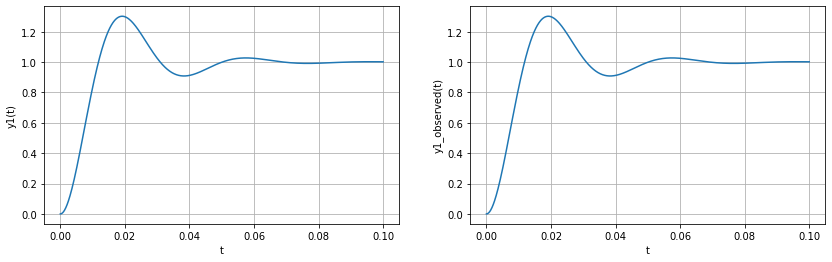

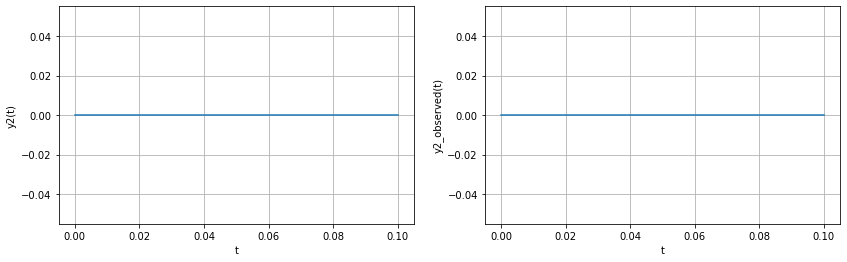

In [11]:
observable = test_observability(sys_original)
assert observable, 'O sistema não é observável!!!'

# Parâmetros desejados
zeta, wn = parameters_from_metrics(Mp=desired_Mp, ts5=desired_ts5/5)
eigenvalues = (np.roots([1, 2*zeta*wn,  wn**2])*4).tolist()

# Projeto
K_obs = control.acker(np.conjugate(A.T), np.conjugate(C.T), eigenvalues).T;
print('Ke =', K_obs)
AA_obs = np.block([[A, np.zeros_like(A)],[K_obs*C, A-K_obs*C]]);
BB_obs = np.block([[B],[B]]);
CC_obs = np.matrix([[1, 0, 0, 0], [0, 0, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]], dtype=np.float64);
DD_obs = np.zeros([2*len(A),1]);
sys_obs = control.ss(AA_obs, BB_obs, CC_obs, DD_obs)

# Verificação
plot_observer_comparison(sys_obs, tfinal = tfinal, initial_conditions = np.matrix([[0], [0], [0], [0]]))

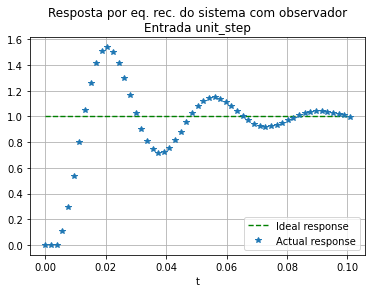

In [12]:
Y_reqeq, t_reqeq, X_reqeq = ee_reqeq_exec_with_observer(
    sys_original = sys_original,
    initial_conditions = np.matrix([[0], [0], [0], [0]]),
    T = T,
    tfinal = tfinal,
    K_obs = K_obs,
)

#  Observador + Controlador
Expanded matrices:
![](controlled_observed_new_system.png)

In [13]:
AA_obs_contr = np.block([[A, B*k_contr_i, -B*K_contr],[-C, 0, np.zeros((1,2))], [K_obs*C, B*k_contr_i, A-B*K_contr-K_obs*C]])
BB_obs_contr = np.block([[np.zeros((2,1))], [1], [np.zeros((2,1))]])
CC_obs_contr = np.block([[C, 0, np.zeros((1,2))]])
DD_obs_contr = np.matrix([0])

{'Mp': 13.666159212363135,
 'tp': 0.01992,
 'ts5': 0.027440000000000003,
 'ts2': 0.038740000000000004,
 'tr': 0.008820000000000001,
 'td': 0.008100000000000001,
 'ess': -1.3630720156809772e-05,
 'final_value_step_simulated': 1.0000136307201568,
 'final_value_step_theoretical': -1}

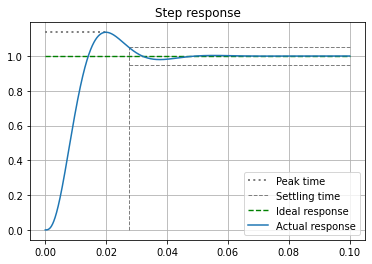

In [23]:
sys_obs_contr = control.ss(AA_obs_contr, BB_obs_contr, CC_obs_contr, DD_obs_contr)
sys_obs_contr_parameters: dict = step_info(sys_obs_contr, tfinal)
sys_obs_contr_parameters

The control signal goes from 0.0 to 1.3944933723545934


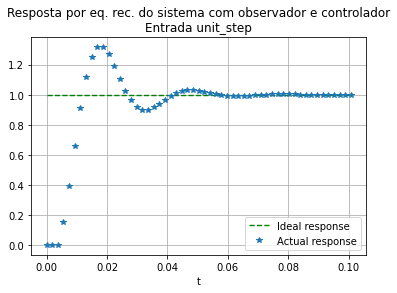

In [15]:
Y_reqeq, t_reqeq, X_reqeq = ee_reqeq_exec_with_observer_and_controller(
    sys_original = sys_original,
    initial_conditions = np.matrix([[0], [0], [0], [0], [0]]),
    T = T,
    tfinal = tfinal,
    K_contr = K_contr,
    k_contr_i = k_contr_i,
    K_obs = K_obs,
)

The control signal goes from 0.0 to 1.6972553988041748


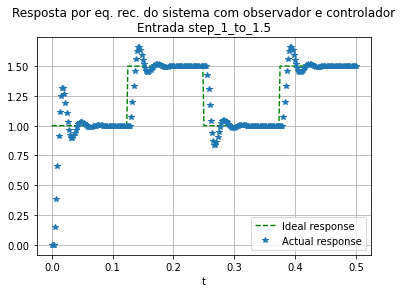

In [16]:
Y_reqeq, t_reqeq, X_reqeq = ee_reqeq_exec_with_observer_and_controller(
    sys_original = sys_original,
    initial_conditions = np.matrix([[0], [0], [0], [0], [0]]),
    T = T,
    tfinal = tfinal*5,
    K_contr = K_contr,
    k_contr_i = k_contr_i,
    K_obs = K_obs,
    input_function = 'step_1_to_1.5',
)

In [22]:
# Checking if requirements are met
print('\nMetrics:')
metrics = sys_obs_contr_parameters
pprint(metrics)

assert metrics['ts5'] < desired_ts5_original/1000
assert metrics['Mp'] < desired_Mp_original
assert metrics['ess'] < 0.00001

display(Markdown('O sistema calculado atende todos os requisitos do protejo, conforme vê ne comparação:'))
pd.DataFrame([
    ['ts5 (ms)', desired_ts5_original, metrics['ts5']*1000],
    ['Mp (%)', desired_Mp_original, metrics['Mp']],
    ['ess (V)', 0, metrics['ess']],
    ['stable', True, metrics['ess']<1]
], columns=['Metric', 'Desired', 'Actual'])


Metrics:
{'Mp': 13.667624590034489,
 'ess': -2.419842104472991e-12,
 'final_value_step_simulated': 1.0000000000024198,
 'final_value_step_theoretical': -1,
 'td': 0.0081,
 'tp': 0.0199,
 'tr': 0.0089,
 'ts2': 0.038700000000000005,
 'ts5': 0.0274}


O sistema calculado atende todos os requisitos do protejo, conforme vê ne comparação:

Metric Desired     Actual
0  ts5 (ms)      33       27.4
1    Mp (%)      16  13.667625
2   ess (V)       0       -0.0
3    stable    True       True